In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

## Getting the Song lyrics Dataset

https://www.kaggle.com/mousehead/songlyrics

### Preprocessing

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  dataset[field] = dataset[field].str.lower()
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  corpus = [l for l in corpus if l != '']
  return corpus

In [4]:
dataset = pd.read_csv('songdata.csv', dtype=str)[:250]
corpus = create_lyrics_corpus(dataset, 'text')
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words
print(total_words)

2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


### Creating sequences and labels

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

input_sequences, labels = sequences[:,:-1], sequences[:,-1]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 19s 7ms/step - loss: 5.9810 - accuracy: 0.0468
Epoch 2/100
1480/1480 [==============================] - 10s 7ms/step - loss: 5.6751 - accuracy: 0.0505
Epoch 3/100
1480/1480 [==============================] - 10s 7ms/step - loss: 5.4586 - accuracy: 0.0692
Epoch 4/100
1480/1480 [==============================] - 11s 7ms/step - loss: 5.2912 - accuracy: 0.0969
Epoch 5/100
1480/1480 [==============================] - 11s 8ms/step - loss: 5.1449 - accuracy: 0.1178
Epoch 6/100
1480/1480 [==============================] - 11s 7ms/step - loss: 5.0163 - accuracy: 0.1310
Epoch 7/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.8904 - accuracy: 0.1413
Epoch 8/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.7708 - accuracy: 0.1521
Epoch 9/100
1480/1480 [==============================] - 11s 8ms/step - loss: 4.6648 - accuracy: 0.1631
Epoch 10/100
1480/1480 [==============================] - 11s 7m

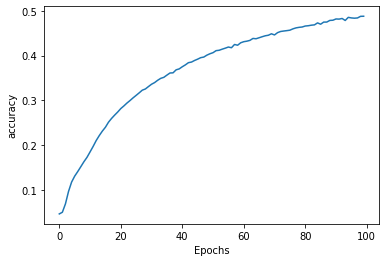

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [10]:
model.save('my_model.h5')